# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"


In [73]:
import jax
import jax.numpy as jnp
import jax_galsim as xgalsim
import matplotlib.pyplot as plt 

from jax import random
from jax import vmap, grad, jit

import galsim

In [133]:
@jax.jit
def render_bd(
    lfb, lfd, ab, ad, qb, qd, beta, x, y, *, psf_hlr=0.7, slen=53, fft_size=256, pixel_scale=0.2
):
    gsparams = xgalsim.GSParams(minimum_fft_size=fft_size, maximum_fft_size=fft_size)

    flux_b = 10**lfb
    flux_d = 10**lfd

    bd = qd*ad
    bb = qb*ab
    
    components = []
    disk_hlr_arcsecs = jnp.sqrt(ad * bd)
    disk = xgalsim.Exponential(flux=flux_d, half_light_radius=disk_hlr_arcsecs).shear(
        q=qd,
        beta=beta * xgalsim.radians,
    )
    components.append(disk)

    bulge_hlr_arcsecs = jnp.sqrt(ab * bb)
    bulge = xgalsim.Spergel(nu=-0.6, flux=flux_b, half_light_radius=bulge_hlr_arcsecs).shear(
        q=qb,
        beta=beta * xgalsim.radians,
    )
    components.append(bulge)

    galaxy = xgalsim.Add(components)    
    psf = xgalsim.Gaussian(flux=1.0, half_light_radius=0.7)
    gal_conv = xgalsim.Convolve([galaxy, psf]).withGSParams(gsparams)
    galaxy_image = gal_conv.drawImage(nx=slen, ny=slen, scale=pixel_scale, offset=(x,y)).array
    return galaxy_image

In [140]:
def render_bd_galsim(
    lfb, lfd, ab, ad, qb, qd, beta, x, y, *, psf_hlr=0.7, slen=53, pixel_scale=0.2
):
    flux_b = 10**lfb
    flux_d = 10**lfd

    bd = qd*ad
    bb = qb*ab
    
    components = []
    disk_q = bd / ad
    disk_hlr_arcsecs = jnp.sqrt(ad * bd)
    disk = galsim.Exponential(flux=flux_d, half_light_radius=disk_hlr_arcsecs).shear(
        q=disk_q,
        beta=beta * galsim.radians,
    )
    components.append(disk)

    bulge_q = bb / ab
    bulge_hlr_arcsecs = jnp.sqrt(ab * bb)
    bulge = galsim.Spergel(nu=-0.6, flux=flux_b, half_light_radius=bulge_hlr_arcsecs).shear(
        q=bulge_q,
        beta=beta * galsim.radians,
    )
    components.append(bulge)

    galaxy = galsim.Add(components)

    
    psf = galsim.Gaussian(flux=1.0, half_light_radius=0.7)
    gal_conv = galsim.Convolve([galaxy, psf])
    galaxy_image = gal_conv.drawImage(nx=slen, ny=slen, scale=pixel_scale, offset=(x,y)).array
    return galaxy_image

In [141]:
from bpd.noise import add_noise 

def get_target_images(
    rng_key,
    galaxy_params,
    *,
    background: float,
    slen: int,
):
    """Single noise realization of multiple galaxies (GalSim)."""
    n_gals = galaxy_params["lfb"].shape[0]
    nkeys = random.split(rng_key, n_gals)

    target_images = []
    for ii in range(n_gals):
        _params = {k: v[ii].item() for k, v in galaxy_params.items()}
        noiseless = render_bd_galsim(**_params, slen=slen)
        target_image = add_noise(nkeys[ii], noiseless, bg=background, n=1)
        assert target_image.shape == (1, slen, slen)
        target_images.append(target_image)

    return jnp.concatenate(target_images, axis=0)

# Timing comparisons

In [144]:
%%time
im1 = render_bd(4., 4., 1.0, 1.2, 0.5, 0.5,jnp.pi/4, 0, 0)

CPU times: user 30.7 ms, sys: 2.84 ms, total: 33.6 ms
Wall time: 31.4 ms


In [145]:
%%time
im2= render_bd_galsim(4., 4., 1.0, 1.2, 0.5, 0.5,jnp.pi/4, 0, 0)

CPU times: user 1.89 ms, sys: 977 μs, total: 2.86 ms
Wall time: 1.92 ms


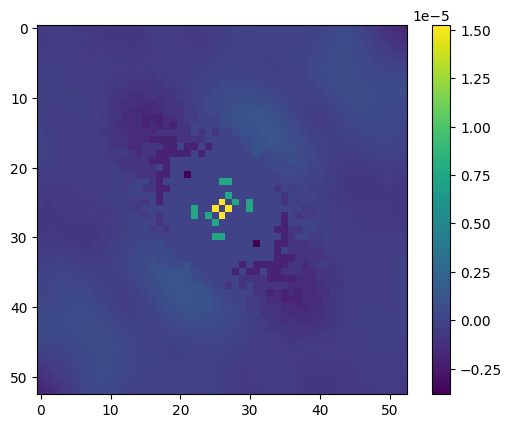

In [146]:
plt.imshow(im1 - im2)
plt.colorbar()

In [151]:
from bpd.draw import draw_gaussian
from functools import partial
draw_fnc = jax.jit(partial(draw_gaussian, slen=53, fft_size=256, ))

In [153]:
%%time 
draw_fnc(100.0, 1.0, 0.2, 0.2, 0.02, 0.0, 0.0, 0.0) # 50 times slower than Gaussian


CPU times: user 0 ns, sys: 2.15 ms, total: 2.15 ms
Wall time: 1.18 ms


Array([[2.1435964e-09, 3.4505589e-09, 5.3109837e-09, ..., 3.2582811e-10,
        3.2513214e-10, 3.2867881e-10],
       [5.9498211e-09, 9.4831858e-09, 1.4616720e-08, ..., 3.1618022e-10,
        3.1585268e-10, 3.2037370e-10],
       [1.5626846e-08, 2.4971046e-08, 3.8735287e-08, ..., 3.1782144e-10,
        3.2021108e-10, 3.2761169e-10],
       ...,
       [3.2761169e-10, 3.2021108e-10, 3.1782144e-10, ..., 3.8735287e-08,
        2.4971046e-08, 1.5626846e-08],
       [3.2037370e-10, 3.1585268e-10, 3.1618022e-10, ..., 1.4616720e-08,
        9.4831858e-09, 5.9498211e-09],
       [3.2867881e-10, 3.2513214e-10, 3.2582811e-10, ..., 5.3109837e-09,
        3.4505589e-09, 2.1435964e-09]], dtype=float32)

# Sampling

In [160]:
def bd_prior(rng_key):
    keys = random.split(rng_key, 10)
    lfd = random.uniform(keys[0], minval=4, maxval=5)
    lfb = random.uniform(keys[1], minval=4, maxval=5)

    ab = random.uniform(keys[2], minval=1, maxval=1.5)
    ad = random.uniform(keys[3], minval=0.9, maxval=1.4)
    
    qb = random.uniform(keys[4], minval=0.1, maxval=1.0)
    qd = random.uniform(keys[5], minval=0.1, maxval=1.0)

    beta = random.uniform(keys[6], minval=0, maxval= 2 * jnp.pi)

    x, y = random.uniform(keys[7], shape=(2,), minval=-0.5, maxval=0.5)

    return {'lfb':lfb, 'lfd':lfd, 'ab':ab, 'ad':ad, 'qb':qb, 'qd':qd, 'beta':beta, 'x':x, 'y':y}


In [208]:
# interim prior
from jax import Array
from typing import Callable
from jax.scipy import stats

def logprior(
    params: dict[str, Array],
    *,
    sigma_x: float = 0.5,  # pixels
) -> Array:
    prior = jnp.array(0.0)

    prior += stats.uniform.logpdf(params["lfb"], -1, 10)
    prior += stats.uniform.logpdf(params["lfd"], -1, 10)
    prior += stats.uniform.logpdf(params["ab"], 0.01, 5.0)
    prior += stats.uniform.logpdf(params["ad"], 0.01, 5.0)

    prior += stats.uniform.logpdf(params["qb"], 0.1, 0.9)
    prior += stats.uniform.logpdf(params["qd"], 0.1, 0.9)
    prior += stats.uniform.logpdf(params["beta"], 0, 2 * jnp.pi)
    

    # NOTE: hard-coded assumption that galaxy is in center-pixel within odd-size image.
    # sigma_x in units of pixels.
    prior += stats.norm.logpdf(params["x"], loc=0.0, scale=sigma_x)
    prior += stats.norm.logpdf(params["y"], loc=0.0, scale=sigma_x)


    return prior


def loglikelihood(
    params: dict[str, Array],
    data: Array,
    *,
    draw_fnc: Callable,
    background: float,
):
    # NOTE: draw_fnc should already contain `f` and `hlr` as constant arguments if fixed
    model = draw_fnc(**params)
    likelihood_pp = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(background))
    return jnp.sum(likelihood_pp)


def logtarget(
    params: dict,
    data: Array,
    *,
    logprior_fnc: Callable,
    loglikelihood_fnc: Callable,
):
    return logprior_fnc(params) + loglikelihood_fnc(params, data)

In [209]:
rng_key = random.key(42) 
k1, k2, k3= random.split(rng_key, 3)

In [210]:
gal_params =vmap(bd_prior)(random.split(k1, 1))
gal_params

{'ab': Array([1.35324196], dtype=float64),
 'ad': Array([1.24063449], dtype=float64),
 'beta': Array([5.18025632], dtype=float64),
 'lfb': Array([4.04650085], dtype=float64),
 'lfd': Array([4.61855626], dtype=float64),
 'qb': Array([0.7817848], dtype=float64),
 'qd': Array([0.49262459], dtype=float64),
 'x': Array([-0.11151964], dtype=float64),
 'y': Array([-0.12520296], dtype=float64)}

In [211]:
images = get_target_images(k2, gal_params, background=1.0, slen=53)

In [220]:
# setup for NUTS
from functools import partial
_draw_fnc  = jit(render_bd)
_logprior = logprior
_loglikelihood = partial(loglikelihood, draw_fnc=_draw_fnc, background=1.0)
_logtarget = partial(logtarget, logprior_fnc=_logprior, loglikelihood_fnc =_loglikelihood)

In [221]:
images.shape

(1, 53, 53)

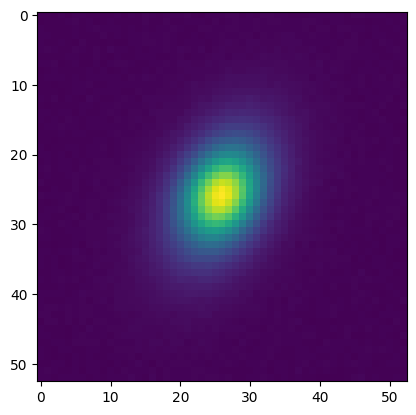

In [222]:
plt.imshow(images[0])

In [223]:
from bpd.chains import run_inference_nuts

In [230]:
_run_inference = jit(partial(run_inference_nuts, logtarget=_logtarget, n_samples=1, initial_step_size=0.1, max_num_doublings=5, is_mass_matrix_diagonal=True, n_warmup_steps=500))

In [231]:
%time samples = vmap(_run_inference)(random.split(k3, 1), gal_params, images) # compile

KeyboardInterrupt: 

In [ ]:
samples['lfb']

In [ ]:
%time samples = vmap(_run_inference)(random.split(k3, 1), gal_params, images) # timing